### Fraud Detection Model: Predicting the Likelihood of Transaction Fraud

Background: Fraud is a critical challenge for banks, taking various forms — from individual credit card theft to large-scale breaches involving stolen card data. These incidents may result from online misuse, skimming devices, or data compromises at merchants, posing significant financial and reputational risks.

Objective: Build a predictive model to determine whether a given transaction will be fraudulent or not.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Instructions for executing the code:
*   Modify the 'directory_path' variable below to specify the location where the data is stored, then execute all cells.

In [ ]:
directory_path = '/path'

In [ ]:
# Importing libraries
import warnings
warnings.filterwarnings("ignore")

import os
import pandas as pd
import numpy as np

from datetime import datetime
import string
from collections import Counter

from scipy.stats import chi2_contingency, f_oneway
from statsmodels.stats.outliers_influence import variance_inflation_factor

import matplotlib
%matplotlib inline
from matplotlib import pyplot
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import plotly.graph_objs as go
import seaborn as sns

from sklearn.feature_selection import RFE
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

import xgboost as xgb

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, roc_curve, auc, roc_auc_score, classification_report, confusion_matrix

##### 1: Data Load

*Importing Dataset*

*The data is in line-delimited JSON format, taken from online source.

In [ ]:
# Importing dataset
# directory_path = '/path'
data_path = directory_path + '/' + "transactions.txt"
data_1 = pd.read_json(data_path, lines=True)

print("Number of records in dataset: ", data_1.shape[0])
print("Number of features in dataset: ", data_1.shape[1])
data_1.head(10)

Number of records in dataset:  786363
Number of features in dataset:  29


,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000,5000.00,2016-08-13T14:27:32,98.55,Uber,US,US,02,...,,0.00,,,,False,,,False,False
1,737265056,737265056,5000,5000.00,2016-10-11T05:05:54,74.51,AMC #191138,US,US,09,...,,0.00,,,,True,,,False,False
2,737265056,737265056,5000,5000.00,2016-11-08T09:18:39,7.47,Play Store,US,US,09,...,,0.00,,,,False,,,False,False
3,737265056,737265056,5000,5000.00,2016-12-10T02:14:50,7.47,Play Store,US,US,09,...,,0.00,,,,False,,,False,False
4,830329091,830329091,5000,5000.00,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US,US,02,...,,0.00,,,,True,,,False,False
5,830329091,830329091,5000,5000.00,2016-04-19T16:24:27,30.76,In-N-Out #422833,US,US,02,...,,0.00,,,,True,,,False,False
6,830329091,830329091,5000,5000.00,2016-05-21T14:50:35,57.28,Krispy Kreme #685312,US,US,02,...,,0.00,,,,True,,,False,False
7,830329091,830329091,5000,5000.00,2016-06-03T00:31:21,9.37,Shake Shack #968081,US,US,05,...,,0.00,,,,True,,,False,False
8,830329091,830329091,5000,4990.63,2016-06-10T01:21:46,523.67,Burger King #486122,,US,02,...,,9.37,,,,True,,,False,False
9,830329091,830329091,5000,5000.00,2016-07-11T10:47:16,164.37,Five Guys #510989,US,US,05,...,,0.00,,,,True,,,False,False


In [ ]:
# Listing all columns in dataset
list(data_1.columns)

['accountNumber',
 'customerId',
 'creditLimit',
 'availableMoney',
 'transactionDateTime',
 'transactionAmount',
 'merchantName',
 'acqCountry',
 'merchantCountryCode',
 'posEntryMode',
 'posConditionCode',
 'merchantCategoryCode',
 'currentExpDate',
 'accountOpenDate',
 'dateOfLastAddressChange',
 'cardCVV',
 'enteredCVV',
 'cardLast4Digits',
 'transactionType',
 'echoBuffer',
 'currentBalance',
 'merchantCity',
 'merchantState',
 'merchantZip',
 'cardPresent',
 'posOnPremises',
 'recurringAuthInd',
 'expirationDateKeyInMatch',
 'isFraud']

In [ ]:
# Count of null for categorical variables
print("acqCountry: ", len(data_1[data_1['acqCountry'] == '']))
print("merchantCountryCode: ", len(data_1[data_1['merchantCountryCode'] == '']))
print("posEntryMode: ", len(data_1[data_1['posEntryMode'] == '']))
print("posConditionCode: ", len(data_1[data_1['posConditionCode'] == '']))
print("transactionType: ", len(data_1[data_1['transactionType'] == '']))
print("echoBuffer: ", len(data_1[data_1['echoBuffer'] == '']))
print("merchantCity: ", len(data_1[data_1['merchantCity'] == '']))
print("merchantState: ", len(data_1[data_1['merchantState'] == '']))
print("merchantZip: ", len(data_1[data_1['merchantZip'] == '']))
print("posOnPremises: ", len(data_1[data_1['posOnPremises'] == '']))
print("recurringAuthInd: ", len(data_1[data_1['recurringAuthInd'] == '']))

acqCountry:  4562
merchantCountryCode:  724
posEntryMode:  4054
posConditionCode:  409
transactionType:  698
echoBuffer:  786363
merchantCity:  786363
merchantState:  786363
merchantZip:  786363
posOnPremises:  786363
recurringAuthInd:  786363


In [ ]:
# Maximum value of date and continuous variables
print("Maximum creditLimit: ", max(data_1.creditLimit))
print("Maximum availableMoney: ", max(data_1.availableMoney))
print("Maximum transactionDateTime: ", max(data_1.transactionDateTime))
print("Maximum transactionAmount: ", max(data_1.transactionAmount))
print("Maximum currentEDate: ", max(data_1.currentExpDate))
print("Maximum accountOpenDate: ", max(data_1.accountOpenDate))
print("Maximum dateOfLastAddressChange: ", max(data_1.dateOfLastAddressChange))
print("Maximum currentBalance: ", max(data_1.currentBalance))

Maximum creditLimit:  50000
Maximum availableMoney:  50000.0
Maximum transactionDateTime:  2016-12-30T23:59:45
Maximum transactionAmount:  2011.54
Maximum currentEDate:  12/2032
Maximum accountOpenDate:  2015-12-31
Maximum dateOfLastAddressChange:  2016-12-30
Maximum currentBalance:  47498.81


In [ ]:
# Minimum value of date and continuous variables
print("Minimum creditLimit: ", min(data_1.creditLimit))
print("Minimum availableMoney: ", min(data_1.availableMoney))
print("Minimum transactionDateTime: ", min(data_1.transactionDateTime))
print("Minimum transactionAmount: ", min(data_1.transactionAmount))
print("Minimum currentExpDate: ", min(data_1.currentExpDate))
print("Minimum accountOpenDate: ", min(data_1.accountOpenDate))
print("Minimum dateOfLastAddressChange: ", min(data_1.dateOfLastAddressChange))
print("Minimum currentBalance: ", min(data_1.currentBalance))

Minimum creditLimit:  250
Minimum availableMoney:  -1005.63
Minimum transactionDateTime:  2016-01-01T00:01:02
Minimum transactionAmount:  0.0
Minimum currentExpDate:  01/2020
Minimum accountOpenDate:  1989-08-22
Minimum dateOfLastAddressChange:  1989-08-22
Minimum currentBalance:  0.0


In [ ]:
# Unique values of variables
print("creditLimit: ", pd.unique(data_1['creditLimit']))
print("\nacqCountry: ", pd.unique(data_1['acqCountry']))
print("\nposEntryMode: ", pd.unique(data_1['posEntryMode']))
print("\nposConditionCode: ", pd.unique(data_1['posConditionCode']))
print("\nmerchantCategoryCode: ", pd.unique(data_1['merchantCategoryCode']))
print("\ntransactionType: ", pd.unique(data_1['transactionType']))
print("\ncardPresent: ", pd.unique(data_1['cardPresent']))
print("\nexpirationDateKeyInMatch: ", pd.unique(data_1['expirationDateKeyInMatch']))
print("\nisFraud: ", pd.unique(data_1['isFraud']))

creditLimit:  [ 5000  2500 50000 15000 10000   250   500  1000  7500 20000]

acqCountry:  ['US' '' 'CAN' 'MEX' 'PR']

posEntryMode:  ['02' '09' '05' '80' '90' '']

posConditionCode:  ['01' '08' '99' '']

merchantCategoryCode:  ['rideshare' 'entertainment' 'mobileapps' 'fastfood' 'food_delivery'
 'auto' 'online_retail' 'gym' 'health' 'personal care' 'food' 'fuel'
 'online_subscriptions' 'online_gifts' 'hotels' 'airline' 'furniture'
 'subscriptions' 'cable/phone']

transactionType:  ['PURCHASE' 'ADDRESS_VERIFICATION' 'REVERSAL' '']

cardPresent:  [False  True]

expirationDateKeyInMatch:  [False  True]

isFraud:  [False  True]


*Chi-Square test: Testing association of categorical variables with the depenedent variable (isFraud).*

In [ ]:
# Identifying categorical columns for Chi-Square test
cat_cols = ['acqCountry', 'merchantCountryCode', 'posEntryMode', 'posConditionCode', 'merchantCategoryCode', 'transactionType', 'cardPresent']

chi_sq_res = pd.DataFrame(columns=['Feature', 'Chi2 Statistic', 'p-value'])

# Performing Chi-Square test for each categorical feature
for col in cat_cols:
    if col in data_1.columns:
        contingency_table = pd.crosstab(data_1[col], data_1['isFraud'])
        chi_sq, p, dof, expected = chi2_contingency(contingency_table)
        chi_sq_res = pd.concat([chi_sq_res, pd.DataFrame([[col, chi_sq, p]], columns=['Feature', 'Chi2 Statistic', 'p-value'])], ignore_index=True)

print("\nChi-Square Test Results:")
print(chi_sq_res.sort_values('p-value'))


Chi-Square Test Results:
                Feature  Chi2 Statistic       p-value
2          posEntryMode     3018.782019  0.000000e+00
4  merchantCategoryCode     3772.066364  0.000000e+00
6           cardPresent     1481.680466  0.000000e+00
1   merchantCountryCode      456.257030  1.928075e-97
3      posConditionCode      229.061215  2.206931e-49
5       transactionType      135.358748  3.785107e-29
0            acqCountry       96.672167  5.024240e-20


Interpreting the Chi-Square test results: A higher Chi-Square value indicates a stronger relationship between the feature and 'isFraud'. A small p-value (< 0.05) suggests a statistically significant relationship.

*   Features Significantly Associated with isFraud (p-value ~ 0):
  *   Strong Association: posEntryMode, merchantCategoryCode, cardPresent.
  *   Statistically Significant Association: merchantCountryCode, posConditionCode, transactionType, acqCountry (very low p-values).

In [ ]:
# Describing continuous variables in dataset
data_1.loc[:, ['creditLimit', 'availableMoney', 'transactionAmount', 'currentBalance']].describe()

,creditLimit,availableMoney,transactionAmount,currentBalance
count,786363.000000,786363.000000,786363.000000,786363.000000
mean,10759.464459,6250.725369,136.985791,4508.739089
std,11636.174890,8880.783989,147.725569,6457.442068
min,250.000000,-1005.630000,0.000000,0.000000
25%,5000.000000,1077.420000,33.650000,689.910000
50%,7500.000000,3184.860000,87.900000,2451.760000
75%,15000.000000,7500.000000,191.480000,5291.095000
max,50000.000000,50000.000000,2011.540000,47498.810000


*ANOVA test: Analyzing variance in numerical features across the isFraud classes.*

In [ ]:
# Identifying numerical columns for ANOVA test
target = 'isFraud'
num_cols = ['creditLimit', 'availableMoney', 'transactionAmount', 'currentBalance']

anova_res = pd.DataFrame(columns=['Feature', 'F-Statistic', 'p-value'])

# Performing ANOVA test for each numerical feature
for col in num_cols:
    if col in data_1.columns:
        groups = [data_1[col][data_1[target] == val] for val in data_1[target].unique()]
        f_stat, p_value = f_oneway(*groups)
        anova_res = pd.concat([anova_res, pd.DataFrame([[col, f_stat, p_value]], columns=['Feature', 'F-Statistic', 'p-value'])], ignore_index=True)

print("\nANOVA Test Results:")
print(anova_res.sort_values('p-value'))


ANOVA Test Results:
             Feature  F-Statistic       p-value
2  transactionAmount  4526.301846  0.000000e+00
3     currentBalance    46.809824  7.827714e-12
0        creditLimit     7.594627  5.854387e-03
1     availableMoney     1.860012  1.726238e-01


Interpretation of the ANOVA test Results: F-Statistic is used to measure the ratio of variance between the groups to the variance within the groups. A higher F-statistic indicates a greater difference between group means. Lower p-values (< 0.05) indicate a significant difference in means across 'isFraud'.

*   transactionAmount, currentBalance, creditLimit: These features show a very
strong difference in mean values between fraudulent and non-fraudulent transactions.
*   availableMoney: This feature does not show a statistically significant difference between fraudulent and non-fraudulent transactions (F-statistic closer to 1, p-value > 0.05).

*Checking for Multicollinearity*

In [ ]:
# Selecting numerical features for multicollinearity check
num_cols = ['creditLimit', 'availableMoney', 'transactionAmount', 'currentBalance']

# Dropping rows with missing values to avoid errors
data_num = data_1[num_cols].dropna()

# Computing VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = num_cols
vif_data["VIF"] = [variance_inflation_factor(data_num.values, i) for i in range(len(num_cols))]

print("\nVariance Inflation Factor (VIF) for Multicollinearity Detection:")
print(vif_data)


Variance Inflation Factor (VIF) for Multicollinearity Detection:
             Feature       VIF
0        creditLimit       inf
1     availableMoney       inf
2  transactionAmount  1.282125
3     currentBalance       inf


*   transactionAmount: This feature is not strongly correlated with any other feature, indicating that it provides unique information (VIF < 10).

*   Since availableMoney = creditLimit - currentBalance, indicates perfect collinearity between these features due to their linear relationship (VIF = infinity).

#### 2: Data Visualization

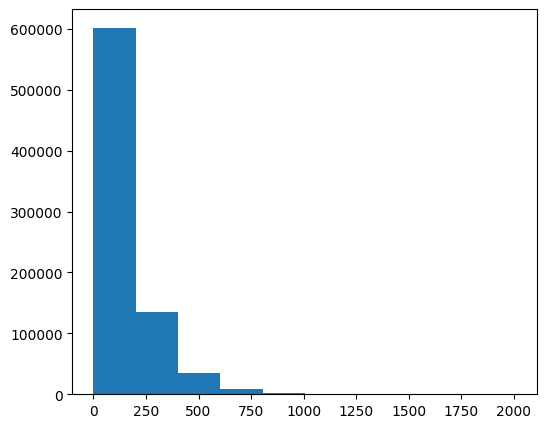

In [ ]:
# Plotting a histogram of the processed amounts of each transaction, the transactionAmount column.
fig, a1 = plt.subplots(figsize =(6, 5))
a1.hist(data_1['transactionAmount'])
plt.show()

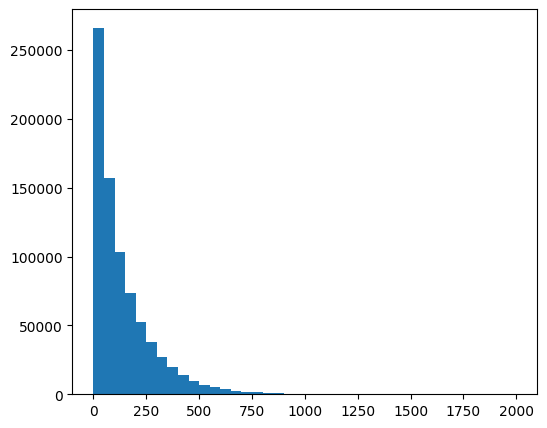

In [ ]:
# Plotting a histogram of transaction amounts with bins ranging from 0 to 2020 at intervals of 50.
fig, a2 = plt.subplots(figsize =(6, 5))
a2.hist(data_1['transactionAmount'], bins = list(range(0,2020,50)))
plt.show()

##### Data Insight - 'transactionAmount'

##### The transaction amounts range from 0 to 2011.54, with most values concentrated between 0 and 200, while transactions above 750 are relatively rare. Additionally, a peak is observed near the lower end of the x-axis (close to zero), suggesting that a large volume of transactions involves small amounts.

##### The histogram of transactionAmount shows a downward trend. The distribution is highly right-skewed (positively skewed), indicating that most transaction amounts are small, while a few are significantly larger. Small transactions are more common (similar to everyday purchases), while very large transactions are rare.

#### 3: Data Wrangling

##### Duplicated transactions in the data set -
##### Reversed transaction - a purchase is followed by a reversal
##### Multi-swipe transaction - a vendor accidentally charges a customer's card multiple times within a short time span

In [ ]:
# Reversed transactions: a purchase is followed by a reversal

# Using transactionType == "REVERSAL" to identify reversal transactions.
df1_reversal = data_1[(data_1['transactionType']=="REVERSAL")]
df1_reversal

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
39,574788567,574788567,2500,2200.98,2016-05-24T01:38:03,215.13,Convenient Tire,US,US,09,...,,299.02,,,,True,,,False,False
73,574788567,574788567,2500,2432.72,2016-10-07T10:23:57,3.87,Eazy Repair,US,US,05,...,,67.28,,,,True,,,False,False
101,924729945,924729945,50000,49831.43,2016-10-19T14:01:45,168.57,discount.com,US,US,05,...,,168.57,,,,False,,,False,False
133,984504651,984504651,50000,46367.41,2016-01-16T09:53:15,450.74,Planet Fitness #849960,US,US,05,...,,3632.59,,,,False,,,False,False
156,984504651,984504651,50000,41909.30,2016-01-25T20:39:15,81.73,AMC #724446,US,US,09,...,,8090.70,,,,True,,,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786106,899818521,899818521,2500,968.33,2016-09-29T02:04:32,10.05,cheapfast.com,US,US,02,...,,1531.67,,,,False,,,False,False
786120,638498773,638498773,10000,9798.21,2016-01-01T19:48:03,201.79,KFC #928167,US,US,05,...,,201.79,,,,True,,,False,False
786219,638498773,638498773,10000,5331.33,2016-11-03T04:23:26,86.14,Dunkin' Donuts #396342,US,US,05,...,,4668.67,,,,True,,,False,False
786225,638498773,638498773,10000,4393.10,2016-11-06T22:54:25,49.39,Shake Shack #118502,US,US,05,...,,5606.90,,,,True,,,False,False


In [ ]:
print("Example of a record with transactionType ='REVERSAL' but no 'Purchase' record in dataset")
print("\nReversal Record", data_1[(data_1['accountNumber']==101661970) & (data_1['transactionType']=='REVERSAL')][['accountNumber','merchantName','transactionType','transactionDateTime','transactionAmount']])
print("\nPurchase Record", data_1[(data_1['accountNumber']==101661970) & (data_1['transactionType']=='PURCHASE') & (data_1['transactionAmount']==18.15)][['accountNumber','merchantName','transactionType','transactionDateTime','transactionAmount']])

Example of a record with transactionType ='REVERSAL' but no 'Purchase' record in dataset

Reversal Record         accountNumber       merchantName transactionType  transactionDateTime  \
470094      101661970  American Airlines        REVERSAL  2016-04-24T14:03:36   

        transactionAmount  
470094              18.15  

Purchase Record Empty DataFrame
Columns: [accountNumber, merchantName, transactionType, transactionDateTime, transactionAmount]
Index: []


In [ ]:
duplicates = data_1[data_1.duplicated(['accountNumber','merchantName','transactionAmount'], keep=False)]

reverse_trans = duplicates[duplicates.transactionType == 'REVERSAL']
purchase_trans = duplicates[duplicates.transactionType == 'PURCHASE']

reverse_trans.rename(columns={'transactionDateTime': 'reversal_trans_date'}, inplace=True)
purchase_trans.rename(columns={'transactionDateTime': 'purchase_trans_date'}, inplace=True)

pur_rev_merged = pd.merge(
    purchase_trans,
    reverse_trans[['accountNumber', 'merchantName', 'transactionAmount', 'reversal_trans_date']],
    on=['accountNumber', 'merchantName', 'transactionAmount'],
    how='inner'
)

print("Records with purchase_trans_datetime > reversal_trans_datetime")
pur_rev_merged[pur_rev_merged.purchase_trans_date > pur_rev_merged.reversal_trans_date][['purchase_trans_date','reversal_trans_date']]

Records with purchase_trans_datetime > reversal_trans_datetime


,purchase_trans_date,reversal_trans_date
843,2016-07-19T20:11:30,2016-05-20T20:57:04
1145,2016-03-14T05:35:50,2016-03-14T05:33:34
1189,2016-05-11T10:45:45,2016-05-11T10:44:29
1190,2016-05-11T10:48:22,2016-05-11T10:44:29
1332,2016-12-13T03:23:22,2016-12-13T03:22:32
...,...,...
16731,2016-11-22T05:32:19,2016-11-22T05:31:10
16909,2016-01-18T04:44:42,2016-01-18T04:44:31
17409,2016-08-29T14:04:47,2016-03-24T07:34:30
17419,2016-10-01T10:07:35,2016-02-16T19:03:34


As demonstrated programmatically above, there are cases where:


*   Records exist with transactionType = 'REVERSAL' but lack a corresponding 'PURCHASE' record in the dataset.
*   Some records have the purchase transaction occurring after the reversal (purchase_trans_datetime > reversal_trans_datetime).

Definition of a Reversed Transaction: A reversed transaction occurs when a purchase is followed by a reversal.

Criteria for Identifying a Reversed Transaction:
1.   Every reversal must have a matching purchase.
2.   The purchase transaction must take place before the reversal, based on transactionDateTime.

In [ ]:
# Reversed transactions: a purchase is followed by a reversal (using above criteria)
reversed_transactions = pur_rev_merged[pur_rev_merged.purchase_trans_date < pur_rev_merged.reversal_trans_date]
reversed_transactions

,accountNumber,customerId,creditLimit,availableMoney,purchase_trans_date,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud,reversal_trans_date
0,574788567,574788567,2500,2416.11,2016-05-24T01:35:33,215.13,Convenient Tire,US,US,09,...,83.89,,,,True,,,False,False,2016-05-24T01:38:03
1,924729945,924729945,50000,50000.00,2016-10-04T04:20:04,168.57,discount.com,US,US,05,...,0.00,,,,False,,,False,False,2016-10-19T14:01:45
2,984504651,984504651,50000,49138.85,2016-01-06T04:08:06,83.64,1st Sandwitch Bar #801388,US,US,09,...,861.15,,,,True,,,False,False,2016-02-04T00:14:42
3,984504651,984504651,50000,46818.15,2016-01-16T09:52:30,450.74,Planet Fitness #849960,US,US,05,...,3181.85,,,,False,,,False,False,2016-01-16T09:53:15
4,984504651,984504651,50000,46341.05,2016-01-17T08:13:08,81.73,AMC #724446,US,US,09,...,3658.95,,,,True,,,False,False,2016-01-25T20:39:15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18138,205026043,205026043,5000,1627.52,2016-09-18T06:07:17,56.26,Lyft,US,US,05,...,3372.48,,,,False,,,False,False,2016-09-18T06:08:02
18139,288358186,288358186,7500,7407.25,2016-08-02T18:42:42,20.66,ebay.com,US,US,09,...,92.75,,,,False,,,False,False,2016-08-28T11:21:32
18140,638498773,638498773,10000,10000.00,2016-01-01T19:45:47,201.79,KFC #928167,US,US,05,...,0.00,,,,True,,,False,False,2016-01-01T19:48:03
18141,638498773,638498773,10000,1271.91,2016-10-09T04:52:23,86.14,Dunkin' Donuts #396342,US,US,05,...,8728.09,,,,True,,,False,False,2016-11-03T04:23:26


In [ ]:
# multi-swipe transactions: a vendor accidentally charges a customer's card multiple times within a short time span.

# Using columns except for transactionDateTime to identify multi-swipe transactions
dup_col_list = ['accountNumber', 'customerId', 'creditLimit', 'availableMoney',
       'transactionAmount', 'merchantName', 'acqCountry', 'merchantCountryCode',
       'posEntryMode', 'posConditionCode', 'merchantCategoryCode', 'currentExpDate',
       'accountOpenDate', 'dateOfLastAddressChange', 'transactionType', 'currentBalance',
        'cardPresent', 'isFraud']

data_1_pur = data_1[(data_1['transactionType']=='PURCHASE')]
data_1_pur_ordered = data_1_pur.sort_values(by=['merchantName', 'customerId', 'transactionDateTime'])
data_1_duplicatedseries = data_1_pur_ordered.duplicated(subset=dup_col_list, keep='first')
data_1_duplicatedseries.unique()
df1_multiswipe = data_1_pur_ordered[data_1_duplicatedseries]
df1_multiswipe

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
494386,528210188,528210188,15000,13314.90,2016-09-14T15:15:29,63.23,1st BBQ,US,US,09,...,,1685.10,,,,True,,,False,False
718858,474934734,474934734,2500,2149.60,2016-03-02T13:56:33,126.29,1st Sandwitch Bar #396252,US,US,05,...,,350.40,,,,True,,,False,False
529269,948561932,948561932,10000,4786.85,2016-01-23T09:11:38,185.56,AMC #145832,US,US,05,...,,5213.15,,,,True,,,False,False
62165,234180315,234180315,15000,9034.90,2016-03-26T02:28:35,53.97,AMC #606218,US,US,05,...,,5965.10,,,,True,,,False,False
685005,376007961,376007961,15000,9327.74,2016-12-02T02:06:48,20.62,AMC #724446,US,US,05,...,,5672.26,,,,True,,,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
552342,990605503,990605503,10000,9995.48,2016-11-20T06:06:39,20.05,netflix.com,US,US,05,...,,4.52,,,,False,,,False,False
552344,990605503,990605503,10000,9995.48,2016-12-21T09:19:40,20.05,netflix.com,US,US,05,...,,4.52,,,,False,,,False,False
206351,995238390,995238390,2500,2500.00,2016-12-12T12:43:57,22.11,netflix.com,US,US,02,...,,0.00,,,,False,,,False,False
186212,373482367,373482367,7500,1098.90,2016-05-25T10:06:03,535.07,oldnavy.com,US,US,02,...,,6401.10,,,,False,,,False,False


In [ ]:
# multi-swipe transactions: a vendor accidentally charges a customer's card multiple times within a short time span.

# Filtering records with a transaction time span of less than 1 hour (Assumption: short time span = within 1 hour)
duplicates = data_1[data_1.duplicated(['customerId', 'transactionAmount', 'merchantName', 'transactionType'],keep=False)]

pur = duplicates[duplicates.transactionType == 'PURCHASE']
pur.sort_values(['customerId', 'merchantName', 'transactionDateTime'])

def calculate_time_diff(df1):
    df1['timespan'] = df1["transactionDateTime"].diff(1).dt.total_seconds() / 3600
    return df1

pur['transactionDateTime'] = pd.to_datetime(pur['transactionDateTime'])
purchases = pur.groupby(['customerId', 'merchantName', 'transactionAmount']).apply(calculate_time_diff)

multi_swipe_transactions = purchases[purchases.timespan < 1]
multi_swipe_transactions

accountNumber  \
customerId merchantName            transactionAmount                         
100088067  Fresh Flowers           411.35            541956      100088067   
100737756  34th BBQ #166379        43.25             151518      100737756   
           Franks Deli             693.50            151427      100737756   
                                                     151428      100737756   
           South Steakhouse #73819 211.22            151513      100737756   
...                                                                    ...   
999086814  apple.com               22.76             389018      999086814   
           sears.com               178.57            388400      999086814   
           staples.com             172.50            388759      999086814   
999257059  Wall Street News        47.58             569654      999257059   
999283629  Delta Airlines          247.40            670027      999283629   

                                                             customerId  \
customerId merchantName            transactionAmount                      
100088067  Fresh Flowers           411.35            541956   100088067   
100737756  34th BBQ #166379        43.25             151518   100737756   
           Franks Deli             693.50            151427   100737756   
                                                     151428   100737756   
           South Steakhouse #73819 211.22            151513   100737756   
...                                                                 ...   
999086814  apple.com               22.76             389018   999086814   
           sears.com               178.57            388400   999086814   
           staples.com             172.50            388759   999086814   
999257059  Wall Street News        47.58             569654   999257059   
999283629  Delta Airlines          247.40            670027   999283629   

                                                             creditLimit  \
customerId merchantName            transactionAmount                       
100088067  Fresh Flowers           411.35            541956        50000   
100737756  34th BBQ #166379        43.25             151518          250   
           Franks Deli             693.50            151427          250   
                                                     151428          250   
           South Steakhouse #73819 211.22            151513          250   
...                                                                  ...   
999086814  apple.com               22.76             389018        10000   
           sears.com               178.57            388400        10000   
           staples.com             172.50            388759        10000   
999257059  Wall Street News        47.58             569654        15000   
999283629  Delta Airlines          247.40            670027         2500   

                                                             availableMoney  \
customerId merchantName            transactionAmount                          
100088067  Fresh Flowers           411.35            541956        49275.09   
100737756  34th BBQ #166379        43.25             151518          177.98   
           Franks Deli             693.50            151427          -44.75   
                                                     151428         -535.03   
           South Steakhouse #73819 211.22            151513          250.00   
...                                                                     ...   
999086814  apple.com               22.76             389018          503.05   
           sears.com               178.57            388400         5450.99   
           staples.com             172.50            388759         5418.98   
999257059  Wall Street News        47.58             569654        14177.84   
999283629  Delta Airlines          247.40            670027         1368.90   

                                                     

*Total number of transactions and total dollar amount for reversed transactions.*

In [ ]:
# Using transactionType == "REVERSAL" to identify reversal transactions.
print("Using transactionType == 'REVERSAL' to identify reversal transactions:")
print("Total number of reversed transactions - ", len(df1_reversal))
print("Total dollar amount for reversed transactions - ", sum(df1_reversal['transactionAmount']))

#  Using 'reversed_transactions' dataframe created above (criteria based) to identify reversal transactions.
print("\nUsing 'reversed_transactions' dataframe created above (criteria based) to identify reversal transactions:")
print("Total number of reversed transactions - ", len(reversed_transactions))
print("Total dollar amount for reversed transactions - ", sum(reversed_transactions['transactionAmount']))

Using transactionType == 'REVERSAL' to identify reversal transactions:
Total number of reversed transactions -  20303
Total dollar amount for reversed transactions -  2821792.4999999753

Using 'reversed_transactions' dataframe created above (criteria based) to identify reversal transactions:
Total number of reversed transactions -  17999
Total dollar amount for reversed transactions -  2701311.8699999885


*Total number of transactions and total dollar amount for multi-swipe transactions (Considering first transaction to be "normal" and excluding it from the number of transactions and dollar amount counts).*

In [ ]:
# Using columns except for transactionDateTime to identify multi-swipe transactions.
print("\nUsing columns except for transactionDateTime to identify multi-swipe transactions:")
print("Total number of multi-swipe transactions - ", len(df1_multiswipe))
print("Total dollar amount for multi-swipe transactions - ", sum(df1_multiswipe['transactionAmount']))

# Using filtered records with a transaction time span of less than 1 hour (Assumption: short time span = within 1 hour).
print("\nUsing filtered records with a transaction time span of less than 1 hour (Assumption: short time span = within 1 hour):")
print("Total number of multi-swipe transactions - ", len(multi_swipe_transactions))
print("Total dollar amount for multi-swipe transactions - ", sum(multi_swipe_transactions['transactionAmount']))


Using columns except for transactionDateTime to identify multi-swipe transactions:
Total number of multi-swipe transactions -  4615
Total dollar amount for multi-swipe transactions -  108389.2399999996

Using filtered records with a transaction time span of less than 1 hour (Assumption: short time span = within 1 hour):
Total number of multi-swipe transactions -  7450
Total dollar amount for multi-swipe transactions -  1103132.2500000026


*Interesting Findings in Reversal transactions*

In [ ]:
# Analyzing Purchase-Reversal Time Gap and Reversal Frequency

# Calculating time difference between purchase and reversal (hours).
reversed_transactions['purchase_trans_date'] = pd.to_datetime(reversed_transactions['purchase_trans_date'])
reversed_transactions['reversal_trans_date'] = pd.to_datetime(reversed_transactions['reversal_trans_date'])
reversed_transactions['time_diff'] = (reversed_transactions['reversal_trans_date'] - reversed_transactions['purchase_trans_date']).dt.total_seconds() / 3600

# Analyzing number of reversed transactions within 1 hour, 1 day, 10 days and 1 month.
rev_within_1_hour = reversed_transactions[reversed_transactions['time_diff'] <= 1].shape[0]
rev_within_24_hours = reversed_transactions[reversed_transactions['time_diff'] <= 24].shape[0]
rev_within_240_hours = reversed_transactions[reversed_transactions['time_diff'] <= 240].shape[0]
rev_within_720_hours = reversed_transactions[reversed_transactions['time_diff'] <= 720].shape[0]

total_reversals = reversed_transactions.shape[0]

print(f"Total reversed transactions: {total_reversals}")
print(f"Reversed transactions within 1 hour: {rev_within_1_hour} ({(rev_within_1_hour / total_reversals) * 100:.2f}%)")
print(f"Reversed transactions within 24 hours: {rev_within_24_hours} ({(rev_within_24_hours / total_reversals) * 100:.2f}%)")
print(f"Reversed transactions within 10 days: {rev_within_240_hours} ({(rev_within_240_hours / total_reversals) * 100:.2f}%)")
print(f"Reversed transactions within 1 month: {rev_within_720_hours} ({(rev_within_720_hours / total_reversals) * 100:.2f}%)")

reversed_transactions[['accountNumber', 'merchantName', 'transactionAmount', 'purchase_trans_date', 'reversal_trans_date', 'time_diff']]

Total reversed transactions: 17999
Reversed transactions within 1 hour: 5576 (30.98%)
Reversed transactions within 24 hours: 5576 (30.98%)
Reversed transactions within 10 days: 9506 (52.81%)
Reversed transactions within 1 month: 17923 (99.58%)


,accountNumber,merchantName,transactionAmount,purchase_trans_date,reversal_trans_date,time_diff
0,574788567,Convenient Tire,215.13,2016-05-24 01:35:33,2016-05-24 01:38:03,0.041667
1,924729945,discount.com,168.57,2016-10-04 04:20:04,2016-10-19 14:01:45,369.694722
2,984504651,1st Sandwitch Bar #801388,83.64,2016-01-06 04:08:06,2016-02-04 00:14:42,692.110000
3,984504651,Planet Fitness #849960,450.74,2016-01-16 09:52:30,2016-01-16 09:53:15,0.012500
4,984504651,AMC #724446,81.73,2016-01-17 08:13:08,2016-01-25 20:39:15,204.435278
...,...,...,...,...,...,...
18138,205026043,Lyft,56.26,2016-09-18 06:07:17,2016-09-18 06:08:02,0.012500
18139,288358186,ebay.com,20.66,2016-08-02 18:42:42,2016-08-28 11:21:32,616.647222
18140,638498773,KFC #928167,201.79,2016-01-01 19:45:47,2016-01-01 19:48:03,0.037778
18141,638498773,Dunkin' Donuts #396342,86.14,2016-10-09 04:52:23,2016-11-03 04:23:26,599.517500


Most of the reversed transactions occur within 24 hours of purchase, indicating quick detection of issues.

In [ ]:
# Reversals without corresponding purchases

rev_without_purchase = pd.merge(
    reverse_trans,
    purchase_trans[['accountNumber', 'merchantName', 'transactionAmount', 'purchase_trans_date']],
    on=['accountNumber', 'merchantName', 'transactionAmount'],
    how='left'
)

print("Total number of reversal transactions without corresponding purchases:", rev_without_purchase[rev_without_purchase['purchase_trans_date'].isna()].shape[0])
print("Total transaction amount of reversals without corresponding purchases:", rev_without_purchase[rev_without_purchase['purchase_trans_date'].isna()]['transactionAmount'].sum())
rev_without_purchase[rev_without_purchase['purchase_trans_date'].isna()]

Total number of reversal transactions without corresponding purchases: 586
Total transaction amount of reversals without corresponding purchases: 2823.9


,accountNumber,customerId,creditLimit,availableMoney,reversal_trans_date,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud,purchase_trans_date
30,114896048,114896048,15000,10451.30,2016-08-03T14:58:19,0.0,amazon.com,US,US,09,...,4548.70,,,,False,,,False,False,NaN
64,101380713,101380713,10000,725.69,2016-12-13T17:22:58,0.0,Lyft,MEX,MEX,02,...,9274.31,,,,False,,,False,False,NaN
75,805566864,805566864,15000,12157.45,2016-07-21T05:39:06,0.0,Regal Cinemas #05791,US,US,05,...,2842.55,,,,False,,,False,False,NaN
114,631747753,631747753,15000,10982.65,2016-06-24T16:49:31,0.0,Auntie Anne's #410136,US,US,05,...,4017.35,,,,False,,,False,False,NaN
182,934061435,934061435,5000,367.22,2016-01-17T19:11:14,0.0,Dunkin' Donuts #48174,US,US,02,...,4632.78,,,,False,,,False,True,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18514,198092241,198092241,7500,3460.81,2016-04-28T12:58:05,0.0,Pottery Barn,US,US,05,...,4039.19,,,,False,,,False,False,NaN
18561,722404979,722404979,7500,6648.86,2016-11-04T21:24:33,0.0,AMC #128743,US,US,05,...,851.14,,,,False,,,False,False,NaN
18583,597074919,597074919,250,250.00,2016-01-27T02:55:18,0.0,apple.com,US,US,09,...,0.00,,,,False,,,False,False,NaN
18675,473474510,473474510,10000,5950.05,2016-06-11T15:56:14,0.0,Best Deli #109276,US,US,02,...,4049.95,,,,False,,,False,False,NaN


586 reversal transactions (total amount of 2823.9) have no matching purchases, indicating potential errors, fraudulent activity or data inconsistencies.

In [ ]:
# Analyzing reversals transactions by merchantCategoryCode

rev_1 = reversed_transactions.copy()
rev_interesting_df1 = rev_1.groupby('merchantCategoryCode', as_index=False)['accountNumber'].count()
rev_interesting_df1.rename(columns={'accountNumber': 'count'}, inplace=True)
rev_interesting_df1.sort_values('count', ascending=False, inplace=True)
rev_interesting_df1

,merchantCategoryCode,count
9,online_retail,4958
3,fastfood,2801
2,entertainment,1961
4,food,1886
8,online_gifts,1712
11,rideshare,1220
7,hotels,895
12,subscriptions,549
1,auto,508
10,personal care,481


Reversals are most common in online retail, followed by fast food, entertainment, food, and online gifts.

In [ ]:
# Analyzing reversals transactions by merchantCountryCode

rev_interesting_df2 = rev_1.groupby('merchantCountryCode', as_index=False)['accountNumber'].count()
rev_interesting_df2.rename(columns={'accountNumber': 'count'}, inplace=True)
rev_interesting_df2.sort_values('count', ascending=False, inplace=True)
rev_interesting_df2

,merchantCountryCode,count
4,US,17806
2,MEX,71
1,CAN,70
3,PR,35
0,,17


Most reversal transactions are from the US.

In [ ]:
# Monthly analysis of reversal transactions.

rev_1['revtrans_monthyear'] = rev_1.apply(lambda x1: (pd.to_datetime(pd.Series(x1['reversal_trans_date']))).dt.strftime('%m/%Y'), axis=1)
print("Number of reversal transactions - \n", rev_1.groupby(['revtrans_monthyear'])['revtrans_monthyear'].count())
print("\ntransactionAmount - \n", rev_1.groupby(['revtrans_monthyear'])['transactionAmount'].sum())
print("\ncurrentBalance - \n", rev_1.groupby(['revtrans_monthyear'])['currentBalance'].sum())
print("\ncreditLimit - \n", rev_1.groupby(['revtrans_monthyear'])['creditLimit'].sum())
print("\navailableMoney - \n", rev_1.groupby(['revtrans_monthyear'])['availableMoney'].sum())

Number of reversal transactions - 
 revtrans_monthyear
01/2016    1008
02/2016    1412
03/2016    1575
04/2016    1519
05/2016    1587
06/2016    1537
07/2016    1557
08/2016    1653
09/2016    1490
10/2016    1582
11/2016    1551
12/2016    1528
Name: revtrans_monthyear, dtype: int64

transactionAmount - 
 revtrans_monthyear
01/2016    146197.69
02/2016    220168.91
03/2016    234825.50
04/2016    227129.19
05/2016    232111.45
06/2016    240805.58
07/2016    233540.62
08/2016    254637.16
09/2016    216112.66
10/2016    237826.99
11/2016    233014.69
12/2016    224941.43
Name: transactionAmount, dtype: float64

currentBalance - 
 revtrans_monthyear
01/2016    3253714.63
02/2016    5542185.63
03/2016    6823252.73
04/2016    7266249.70
05/2016    7313498.43
06/2016    7318960.68
07/2016    7404361.80
08/2016    8111091.23
09/2016    7645797.91
10/2016    8041827.92
11/2016    7596469.31
12/2016    8003755.50
Name: currentBalance, dtype: float64

creditLimit - 
 revtrans_monthyear
01/2

Reversal transactions increased sharply from February 2016 onwards, with a significant jump from January to February. This trend is also reflected in the total transaction amount, current balance, credit limit, and available money.

*Interesting Findings in Multi-Swipe transactions*

In [ ]:
# Identifying customers with repeated multi-swipes at the same merchant

multiswipe_1 = multi_swipe_transactions.reset_index(drop=True).copy()

merchant_swipe = multiswipe_1.groupby(['customerId', 'merchantName']).size().reset_index(name='swipe_count')

# Filtering customers with more than 2 multi-swipes at the same merchant
same_merchant_swipe = merchant_swipe[merchant_swipe['swipe_count'] >= 2]
same_merchant_swipe = same_merchant_swipe.sort_values(['swipe_count'], ascending=False)

print("Customers with repeated multi-swipes at the same merchant:")
print(same_merchant_swipe.head(20))

Customers with repeated multi-swipes at the same merchant:
      customerId                   merchantName  swipe_count
1820   380680241                Next Day eCards           52
1809   380680241  Blue Mountain Online Services           50
1818   380680241                  Mobile eCards           46
1813   380680241          Fresh Online Services           41
1812   380680241                  Fresh Flowers           38
1814   380680241                   Fresh eCards           36
1810   380680241           Blue Mountain eCards           33
1819   380680241       Next Day Online Services           31
5362   960197435                           Uber           14
4516   832842201                           Lyft           11
4522   832842201                           Uber           11
2362   454175276                           Uber           10
1690   369308035                     target.com           10
2145   419709514                       ebay.com            9
1682   369308035          

Customer '380680241' has an unusually high number of multi-swipes across various merchants, indicating potential system errors or credit abuse.

Other customers also experience frequent multi-swipes on ride-sharing and major e-commerce platforms, indicating possible billing inconsistencies.

In [ ]:
# Analyzing frequency of time differences

time_diff_cnts = purchases.reset_index(drop=True).copy()
time_diff_cnts = time_diff_cnts['timespan'].round(2).value_counts().sort_values(ascending=False)
time_diff_cnts

,count
timespan,
0.04,1541
0.02,1531
0.03,1438
0.01,1428
0.05,773
...,...
149.39,1
157.90,1
5702.88,1


Most multi-swipes happen within a few minutes.

In [ ]:
# Analyzing multi swipe transactions by merchantCategoryCode

ms_interesting_df1 = multiswipe_1.groupby('merchantCategoryCode', as_index=False)['accountNumber'].count()
ms_interesting_df1.rename(columns={'accountNumber': 'count'}, inplace=True)
ms_interesting_df1.sort_values('count', ascending=False, inplace=True)
ms_interesting_df1

,merchantCategoryCode,count
9,online_retail,2054
3,fastfood,1192
2,entertainment,859
4,food,769
8,online_gifts,669
11,rideshare,510
7,hotels,337
12,subscriptions,232
10,personal care,207
1,auto,202


##### Most multi-swipe transactions come from the top five categories: online_retail, fastfood, entertainment, food, and online gifts.

In [ ]:
# Analyzing multi swipe transactions by merchantCountryCode

ms_interesting_df2 = multiswipe_1.groupby('merchantCountryCode', as_index=False)['accountNumber'].count()
ms_interesting_df2.rename(columns={'accountNumber': 'count'}, inplace=True)
ms_interesting_df2.sort_values('count', ascending=False, inplace=True)
ms_interesting_df2

,merchantCountryCode,count
4,US,7387
2,MEX,31
1,CAN,20
3,PR,11
0,,1


##### Most multi-swipe transactions originate from the merchant country 'US'.

#### 4: Predictive Model

Developing a predictive model to identify whether a transaction is fraudulent or not.

*Exploratory Data Analysis*

In [ ]:
print("Total amount of fraud transactions:",data_1[(data_1.isFraud == True)]['transactionAmount'].mean())
print("Total amount of non-fraud transactions:",data_1[(data_1.isFraud == False)]['transactionAmount'].mean())

Total amount of fraud transactions: 225.21590480792463
Total amount of non-fraud transactions: 135.5702486219969


The average transaction amount for fraudulent transactions is higher than that for non-fraudulent transactions.

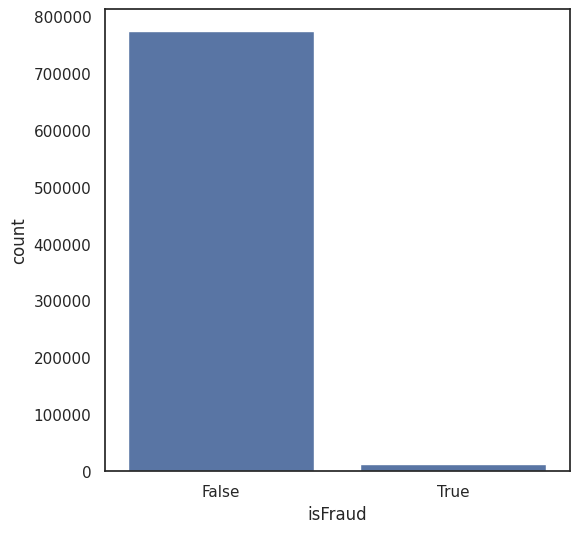

Number of Fraud Transactions = 12417
Number of Non-Fraud Transactions = 773946


In [ ]:
# Class imbalance
matplotlib.rcParams['figure.figsize'] = (6, 6)
sns.set(style="white")
sns.countplot(x='isFraud', data=data_1)
plt.show()

print("Number of Fraud Transactions =", len(data_1[data_1['isFraud']==True]))
print("Number of Non-Fraud Transactions =", len(data_1[data_1['isFraud']==False]))

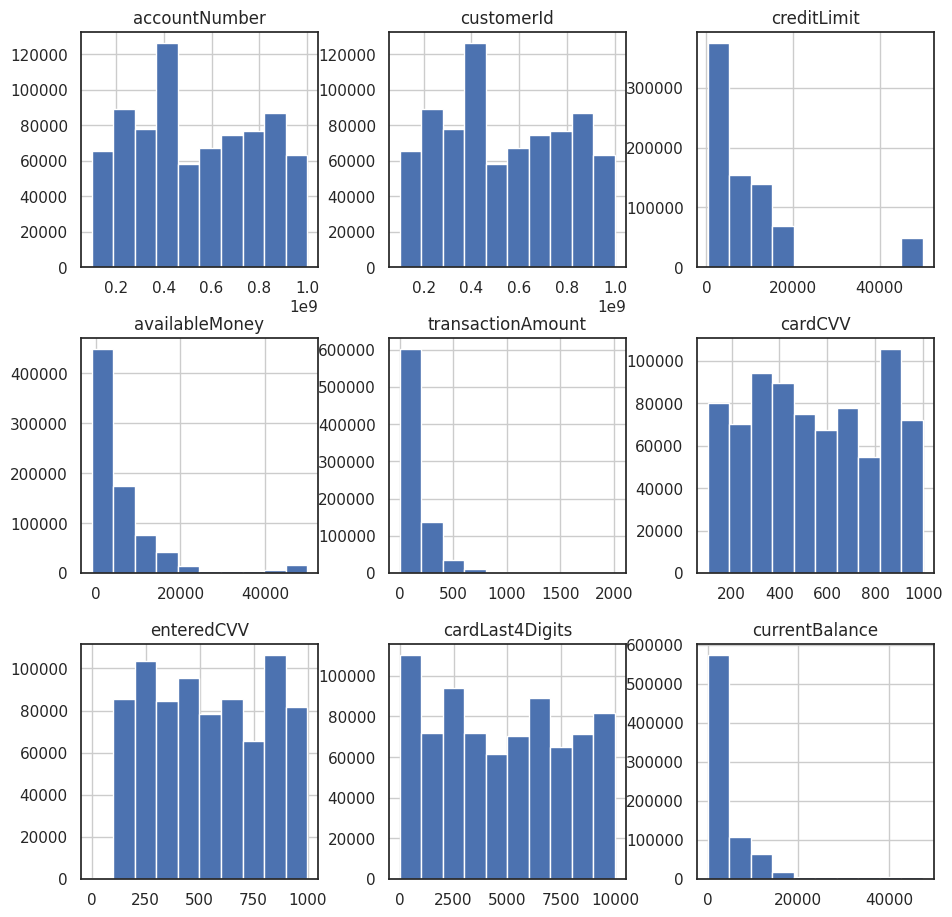

In [ ]:
# Creating histogram
data_1.hist(bins=10, figsize=(11,11))
plt.savefig("histograms")
plt.show()

<Axes: >

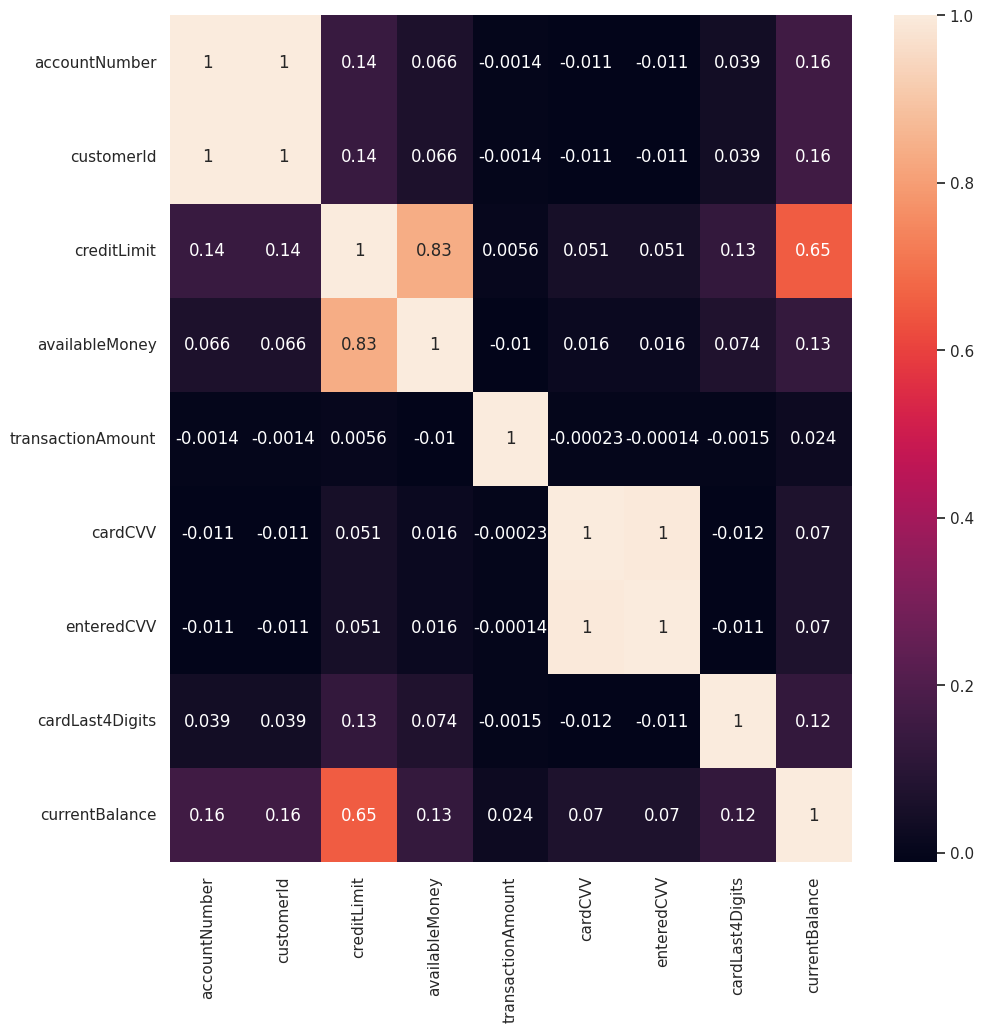

In [ ]:
# Creating correlation matrix
matplotlib.rcParams['figure.figsize'] = (11.0, 11.0)
num_data = data_1.select_dtypes(include=np.number)
sns.heatmap(num_data.corr(), annot=True)

In [ ]:
# Correlation between numerical features
data_1[num_cols].corr()

,creditLimit,availableMoney,transactionAmount,currentBalance
creditLimit,1.000000,0.834977,0.005581,0.653652
availableMoney,0.834977,1.000000,-0.010070,0.129332
transactionAmount,0.005581,-0.010070,1.000000,0.023905
currentBalance,0.653652,0.129332,0.023905,1.000000


In [ ]:
# Correlation of features with the target variable 'isFraud'

data_1['isFraud_num'] = np.where(data_1['isFraud'] == True, 1, 0)

corr_matrix = data_1.select_dtypes(include=np.number).corr()
corr_matrix['isFraud_num'].sort_values(ascending=False)

,isFraud_num
isFraud_num,1.000000
transactionAmount,0.075651
enteredCVV,0.008655
cardCVV,0.008652
currentBalance,0.007715
creditLimit,0.003108
cardLast4Digits,0.000886
availableMoney,-0.001538
customerId,-0.004011
accountNumber,-0.004011


*Feature Engineering (Adding derived features)*

In [ ]:
data_1.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud,isFraud_num
0,737265056,737265056,5000,5000.0,2016-08-13T14:27:32,98.55,Uber,US,US,02,...,0.0,,,,False,,,False,False,0
1,737265056,737265056,5000,5000.0,2016-10-11T05:05:54,74.51,AMC #191138,US,US,09,...,0.0,,,,True,,,False,False,0
2,737265056,737265056,5000,5000.0,2016-11-08T09:18:39,7.47,Play Store,US,US,09,...,0.0,,,,False,,,False,False,0
3,737265056,737265056,5000,5000.0,2016-12-10T02:14:50,7.47,Play Store,US,US,09,...,0.0,,,,False,,,False,False,0
4,830329091,830329091,5000,5000.0,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US,US,02,...,0.0,,,,True,,,False,False,0


In [ ]:
# Calculating age of account in days
data_1['transactionDateTime'] = pd.to_datetime(data_1['transactionDateTime'])
data_1['accountOpenDate'] = pd.to_datetime(data_1['accountOpenDate'])

data_1['account_age_days'] = (data_1['transactionDateTime'] - data_1['accountOpenDate']).dt.days
data_1[['transactionDateTime', 'accountOpenDate', 'account_age_days']].head()

,transactionDateTime,accountOpenDate,account_age_days
0,2016-08-13 14:27:32,2015-03-14,518
1,2016-10-11 05:05:54,2015-03-14,577
2,2016-11-08 09:18:39,2015-03-14,605
3,2016-12-10 02:14:50,2015-03-14,637
4,2016-03-24 21:04:46,2015-08-06,231


Adding 'account_age_days' as a feature to the dataset: Newer accounts are more likely to show unusual behavior and may be more prone to fraudulent activity than older accounts.

In [ ]:
# Calculating utilization ratio
data_1['utilization_ratio'] = data_1['currentBalance'] / data_1['creditLimit']
data_1[['currentBalance', 'creditLimit', 'utilization_ratio']].tail()

,currentBalance,creditLimit,utilization_ratio
786358,1095.04,50000,0.021901
786359,1214.96,50000,0.024299
786360,1233.85,50000,0.024677
786361,1283.28,50000,0.025666
786362,1333.17,50000,0.026663


Combining Related Features: Adding 'utilization ratio' (current balance/credit limit) captures their relationship in a single feature. Higher utilization often signals higher risk, making it a stronger predictor for fraud.

It also reduces multicollinearity (correlation: 0.65) by combining both variables.

In [ ]:
# Adding time-based features

data_1['transactionDateTime'] = pd.to_datetime(data_1['transactionDateTime'])

# Transactions at different hours might indicate different behaviors, such as higher fraud risks at night.
data_1['transaction_hour'] = data_1['transactionDateTime'].dt.hour

# Certain days (like weekends) may have different transaction patterns, which could be useful for fraud detection.
data_1['transaction_dayofweek'] = data_1['transactionDateTime'].dt.weekday

# Transactions occurring on weekends may have distinct behaviors compared to weekdays.
data_1['is_weekend'] = (data_1['transaction_dayofweek'] >= 5).astype(int)

In [ ]:
# Additional derived features

data_1 = data_1.sort_values(['accountNumber', 'transactionDateTime'])

# Time since last transaction (in seconds)
data_1['time_since_last_txn'] = data_1.groupby('accountNumber')['transactionDateTime'].diff().dt.total_seconds().fillna(0)

# Night-time transaction indicator (1 if between 10 PM - 6 AM, else 0)
data_1['is_night'] = data_1['transaction_hour'].apply(lambda x: 1 if (x >= 22 or x <= 6) else 0)

# Transaction amount compared to user's average spending
data_1['amount_vs_avg'] = data_1['transactionAmount'] / data_1.groupby('accountNumber')['transactionAmount'].transform('mean')

# High transaction amount flag (1 if > $5000, else 0)
data_1['is_high_amount'] = (data_1['transactionAmount'] > 5000).astype(int)

# Utilization ratio compared to user's average
data_1['utilization_vs_avg'] = data_1['utilization_ratio'] / data_1.groupby('accountNumber')['utilization_ratio'].transform('mean')

# New user flag (1 if account age < 30 days, else 0)
data_1['is_new_user'] = (data_1['account_age_days'] < 30).astype(int)

# New merchant flag (1 if first-time transaction with a merchant, else 0)
data_1['new_merchant'] = ~data_1.groupby('accountNumber')['merchantCategoryCode'].transform('nunique') > 1

# Cross-border transaction flag (1 if transaction country differs from account country, else 0)
data_1['cross_border'] = (data_1['merchantCountryCode'] != data_1['acqCountry']).astype(int)

# Count of past fraudulent transactions by the user
data_1['user_fraud_history'] = data_1.groupby('accountNumber')['isFraud'].transform('sum')

# Fraud rate per merchant category
fraud_by_merchant = data_1.groupby('merchantCategoryCode')['isFraud'].mean()
data_1['merchant_fraud_rate'] = data_1['merchantCategoryCode'].map(fraud_by_merchant)

# Fraud rate per merchant name (encoding merchant risk)
merchant_fraud_rate = data_1.groupby('merchantName')['isFraud'].mean()
data_1['merchantName_enc'] = data_1['merchantName'].map(merchant_fraud_rate)

# Frequency of transactions per merchant category (normalized)
freq_map = data_1['merchantCategoryCode'].value_counts(normalize=True)
data_1['merchant_freq'] = data_1['merchantCategoryCode'].map(freq_map)

# Transaction amount multiplied by utilization ratio (Interaction)
data_1['amount_x_utilization'] = data_1['transactionAmount'] * data_1['utilization_ratio']

*Feature Selection*

In [ ]:
data_1.columns

Index(['accountNumber', 'customerId', 'creditLimit', 'availableMoney',
       'transactionDateTime', 'transactionAmount', 'merchantName',
       'acqCountry', 'merchantCountryCode', 'posEntryMode', 'posConditionCode',
       'merchantCategoryCode', 'currentExpDate', 'accountOpenDate',
       'dateOfLastAddressChange', 'cardCVV', 'enteredCVV', 'cardLast4Digits',
       'transactionType', 'echoBuffer', 'currentBalance', 'merchantCity',
       'merchantState', 'merchantZip', 'cardPresent', 'posOnPremises',
       'recurringAuthInd', 'expirationDateKeyInMatch', 'isFraud',
       'isFraud_num', 'account_age_days', 'utilization_ratio',
       'transaction_hour', 'transaction_dayofweek', 'is_weekend',
       'time_since_last_txn', 'is_night', 'amount_vs_avg', 'is_high_amount',
       'utilization_vs_avg', 'is_new_user', 'new_merchant', 'cross_border',
       'user_fraud_history', 'merchant_fraud_rate', 'merchantName_enc',
       'merchant_freq', 'amount_x_utilization'],
      dtype='object')

In [ ]:
data_1['isFraud_num'] = np.where(data_1['isFraud'] == True, 1, 0)
data_2 = data_1[['posEntryMode','merchantCategoryCode','merchantName','cardPresent','merchantCountryCode','posConditionCode','transactionType','acqCountry','transactionAmount','account_age_days','utilization_ratio','transaction_hour','transaction_dayofweek','is_weekend'
,'time_since_last_txn', 'is_night', 'amount_vs_avg', 'is_high_amount', 'utilization_vs_avg', 'is_new_user', 'new_merchant', 'cross_border', 'user_fraud_history', 'merchant_fraud_rate', 'merchantName_enc', 'merchant_freq', 'amount_x_utilization'
,'isFraud_num']]

data_2.head()

,posEntryMode,merchantCategoryCode,merchantName,cardPresent,merchantCountryCode,posConditionCode,transactionType,acqCountry,transactionAmount,account_age_days,...,utilization_vs_avg,is_new_user,new_merchant,cross_border,user_fraud_history,merchant_fraud_rate,merchantName_enc,merchant_freq,amount_x_utilization,isFraud_num
541900,02,entertainment,EZ Putt Putt #982199,True,US,01,PURCHASE,US,205.13,733,...,0.000000,0,False,0,1,0.011998,0.011224,0.101859,0.000000,0
541901,05,food,Dinosaur Sandwitch Bar #303701,True,US,01,PURCHASE,US,46.43,733,...,0.866442,0,False,0,1,0.013432,0.008568,0.095999,0.190484,0
541902,05,online_gifts,Mobile eCards,False,US,01,PURCHASE,US,378.67,738,...,1.062556,0,False,0,1,0.024246,0.013981,0.084233,1.905165,0
541903,02,entertainment,EZ Putt Putt #40513,True,US,01,PURCHASE,US,66.07,754,...,0.000000,0,False,0,1,0.011998,0.017776,0.101859,0.000000,0
541904,09,food,34th BBQ #412895,True,US,08,PURCHASE,US,141.60,755,...,0.279071,0,False,0,1,0.013432,0.010695,0.095999,0.187110,0


*Handling Missing Values (Data Preprocessing)*

In [ ]:
# Handling missing values
data_2['posEntryMode'] = data_2['posEntryMode'].fillna('None')
data_2['merchantName'] = data_2['merchantName'].fillna('None')
data_2['merchantCountryCode'] = data_2['merchantCountryCode'].fillna('None')
data_2['posConditionCode'] = data_2['posConditionCode'].fillna('None')
data_2['transactionType'] = data_2['transactionType'].fillna('None')
data_2['acqCountry'] = data_2['acqCountry'].fillna('None')
data_2['new_merchant'] = data_2['new_merchant'].fillna('None')
data_2['is_night'] = data_2['is_night'].fillna('None')
data_2['is_high_amount'] = data_2['is_high_amount'].fillna('None')
data_2['is_new_user'] = data_2['is_new_user'].fillna('None')
data_2['cross_border'] = data_2['cross_border'].fillna('None')
data_2['user_fraud_history'] = data_2['user_fraud_history'].fillna('None')

data_2.fillna(0, inplace=True)
data_2.head()

,posEntryMode,merchantCategoryCode,merchantName,cardPresent,merchantCountryCode,posConditionCode,transactionType,acqCountry,transactionAmount,account_age_days,...,utilization_vs_avg,is_new_user,new_merchant,cross_border,user_fraud_history,merchant_fraud_rate,merchantName_enc,merchant_freq,amount_x_utilization,isFraud_num
541900,02,entertainment,EZ Putt Putt #982199,True,US,01,PURCHASE,US,205.13,733,...,0.000000,0,False,0,1,0.011998,0.011224,0.101859,0.000000,0
541901,05,food,Dinosaur Sandwitch Bar #303701,True,US,01,PURCHASE,US,46.43,733,...,0.866442,0,False,0,1,0.013432,0.008568,0.095999,0.190484,0
541902,05,online_gifts,Mobile eCards,False,US,01,PURCHASE,US,378.67,738,...,1.062556,0,False,0,1,0.024246,0.013981,0.084233,1.905165,0
541903,02,entertainment,EZ Putt Putt #40513,True,US,01,PURCHASE,US,66.07,754,...,0.000000,0,False,0,1,0.011998,0.017776,0.101859,0.000000,0
541904,09,food,34th BBQ #412895,True,US,08,PURCHASE,US,141.60,755,...,0.279071,0,False,0,1,0.013432,0.010695,0.095999,0.187110,0


##### Using XGBoost Model for Classification

Given the large and imbalanced dataset, XGBoost is an ideal choice for handling the classification task efficiently. It is a powerful gradient boosting algorithm that iteratively learns from previous trees, correcting their errors to enhance model performance.

Key advantages of using XGBoost:
*   Mitigates overfitting through advanced regularization techniques.
*   Effectively handles both categorical and continuous variables.
*   Minimizes variance, leading to improved accuracy.
*   Is inherently robust to outliers, managing them automatically.
*   Offers built-in support for imbalanced datasets via scale_pos_weight and sampling strategies.

*Feature Encoding and Train-Test Data Split*

In [ ]:
X = data_2[['posEntryMode', 'merchantCategoryCode', 'cardPresent', 'merchantCountryCode',
            'posConditionCode', 'transactionType', 'acqCountry', 'transactionAmount',
            'account_age_days', 'utilization_ratio','transaction_hour','transaction_dayofweek','is_weekend',
            'time_since_last_txn', 'is_night', 'amount_vs_avg', 'is_high_amount', 'utilization_vs_avg', 'is_new_user',
            'new_merchant', 'cross_border', 'user_fraud_history', 'merchant_fraud_rate', 'merchantName_enc', 'merchant_freq', 'amount_x_utilization']]


# Feature Encoding (for categorical features)
label_encoder = LabelEncoder()
X['posEntryMode'] = label_encoder.fit_transform(X['posEntryMode'])
X['merchantCategoryCode'] = label_encoder.fit_transform(X['merchantCategoryCode'])
X['cardPresent'] = label_encoder.fit_transform(X['cardPresent'])
X['merchantCountryCode'] = label_encoder.fit_transform(X['merchantCountryCode'])
X['posConditionCode'] = label_encoder.fit_transform(X['posConditionCode'])
X['transactionType'] = label_encoder.fit_transform(X['transactionType'])
X['acqCountry'] = label_encoder.fit_transform(X['acqCountry'])
X['is_weekend'] = label_encoder.fit_transform(X['is_weekend'])
X['new_merchant'] = label_encoder.fit_transform(X['new_merchant'])


y = data_2['isFraud_num']

# Spitting dataset into 80-20 train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(629090, 26) (629090,) (157273, 26) (157273,)


*Training Data Resampling*

In [ ]:
# Upsampling minority class using SMOTE

smote = SMOTE(sampling_strategy=0.75, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(X_train.shape, y_train.shape)
X_train_resampled.shape, y_train_resampled.shape

(629090, 26) (629090,)


((1083523, 26), (1083523,))

In [ ]:
y_train_resampled.value_counts(), y_test.value_counts()

(isFraud_num
 0    619156
 1    464367
 Name: count, dtype: int64,
 isFraud_num
 0    154790
 1      2483
 Name: count, dtype: int64)

*XGBoost Model: Using original train data*

[0 0 0 ... 0 0 0]
Classification Report:
              precision    recall  f1-score   support

          No       0.99      1.00      0.99    154790
         Yes       0.83      0.12      0.21      2483

    accuracy                           0.99    157273
   macro avg       0.91      0.56      0.60    157273
weighted avg       0.98      0.99      0.98    157273



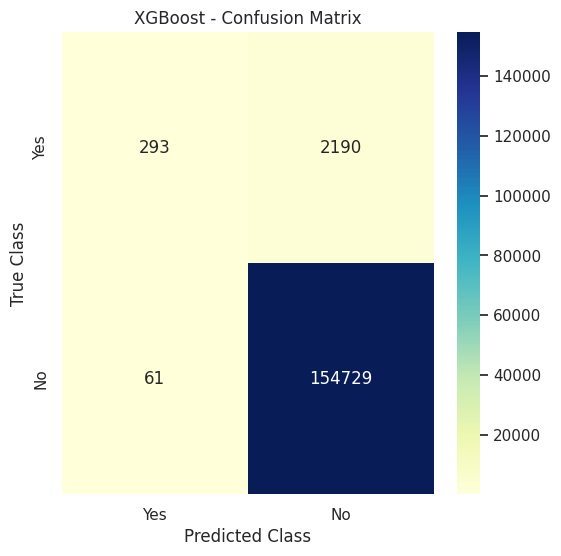

In [ ]:
# Simple XGBoost model using original train data

xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
print(y_pred)

# Evaluating model performance
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["No", "Yes"]))

# Confusion Matrix
matplotlib.rcParams['figure.figsize'] = (6, 6)
xgb_cm = confusion_matrix(y_test, y_pred)
xgb_cm = np.flip(xgb_cm)
sns.heatmap(xgb_cm, cmap='YlGnBu', annot=True, fmt='.0f', xticklabels=["Yes", "No"], yticklabels=["Yes", "No"])
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.title('XGBoost - Confusion Matrix')
plt.savefig('XGBoost_Confusion_Matrix')
plt.show()

In [ ]:
y_test.value_counts()

,count
isFraud_num,
0,154790
1,2483


*XGBoost Model: Training, Hyperparameter Optimization, and Cross-Validation for Imbalanced Data Classification*


In [ ]:
# XGBoost Model Training with Hyperparameter Optimization and Cross-Validation for Imbalanced Data Classification

categorical_columns = ['posEntryMode', 'merchantCategoryCode', 'cardPresent', 'merchantCountryCode', 'posConditionCode', 'transactionType', 'acqCountry', 'is_weekend', 'new_merchant']
for col in categorical_columns:
    X_train_resampled[col] = X_train_resampled[col].astype('category')
    X_test[col] = X_test[col].astype('category')


# Calculating class imbalance ratio
pos_class_count = np.sum(y_train_resampled == 1)
neg_class_count = np.sum(y_train_resampled == 2)
scale_pos_weight = neg_class_count / pos_class_count
print(f"Scale Pos Weight: {scale_pos_weight:.2f}")


# XGBoost model
xgb_model = xgb.XGBClassifier(
    enable_categorical=True,
    objective='binary:logistic',
    eval_metric='aucpr',
    random_state=6,
    verbosity=2,
    tree_method='hist',
    device='cuda'
)


# Hyperparameter grid
param_grid = {
    'scale_pos_weight': [scale_pos_weight, scale_pos_weight*10, scale_pos_weight*20, 30, 50, 70, 90],        # Handling class imbalance using scale_pos_weight
    'max_depth': [3, 5, 7],                                                                                  # Depth of trees
    'learning_rate': [0.03, 0.05],                                                                           # Shrinkage, Step size
    'n_estimators': [500, 800],                                                                              # Number of boosting rounds
    'reg_lambda': [5, 10],                                                                                   # L2 regularization
    'reg_alpha': [1, 3],                                                                                     # L1 regularization
}


# Stratified K-Fold Cross Validation
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=6)


# Randomized Search with Stratified K-Fold
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    scoring='average_precision',            # Prioritizing 'average_precision' for imbalanced data
    cv=stratified_kfold,
    n_iter=10,
    verbose=2,
    n_jobs=-1,
    refit=True
)


# Fitting the model using Stratified K-Fold
random_search.fit(X_train_resampled, y_train_resampled, verbose=1)


# Best parameters from Randomized Search
print("Best Parameters:", random_search.best_params_)

Scale Pos Weight: 0.00
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'scale_pos_weight': 70, 'reg_lambda': 5, 'reg_alpha': 1, 'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.05}


*Model Evaluation and Visualizations: Recall and AUC Score*

Classification Report:
              precision    recall  f1-score   support

          No       1.00      0.67      0.80    154790
         Yes       0.04      0.84      0.08      2483

    accuracy                           0.67    157273
   macro avg       0.52      0.76      0.44    157273
weighted avg       0.98      0.67      0.79    157273



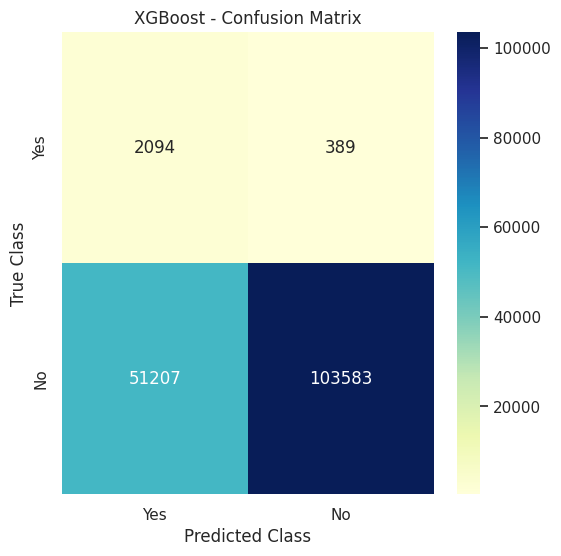

In [ ]:
# Predicting using the best model
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)


# Evaluating model performance
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["No", "Yes"]))

# Confusion Matrix
matplotlib.rcParams['figure.figsize'] = (6, 6)
xgb_cm = confusion_matrix(y_test, y_pred)
xgb_cm = np.flip(xgb_cm)

sns.heatmap(xgb_cm, cmap='YlGnBu', annot=True, fmt='.0f', xticklabels=["Yes", "No"], yticklabels=["Yes", "No"])
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.title('XGBoost - Confusion Matrix')
plt.savefig('XGBoost_Confusion_Matrix')
plt.show()

In [ ]:
y_test.value_counts()

,count
isFraud_num,
0,154790
1,2483


AUC-ROC Score: 0.8451558549555024 



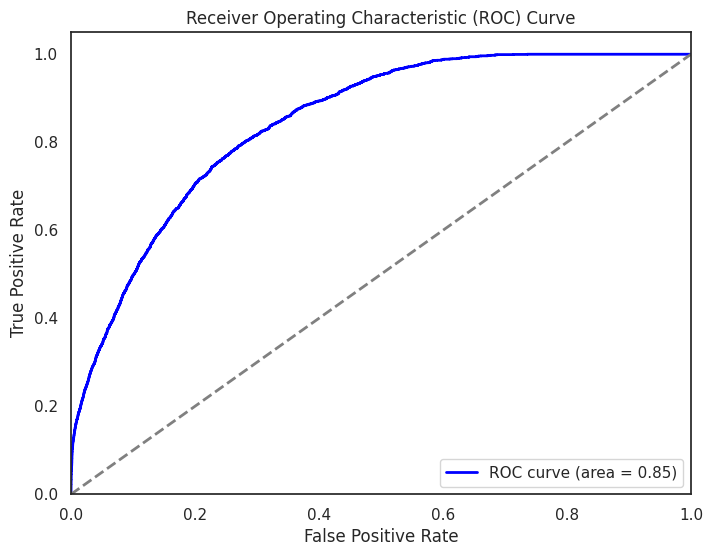

In [ ]:
# Predicting probabilities for test data
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# AUC-ROC Score
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
print("AUC-ROC Score:", roc_auc, "\n")

# ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # Diagonal line for random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

plt.savefig('XGBoost_ROC_Curve.png')
plt.show()

**Using XGBoost, the AUC Score is 85% and Recall is 84% on test data.**


**Methodology:**


1.   Exploratory Data Analyis: to identify key fraud indicators.

  *   Conducted a Chi-Square Test: to assess associations between categorical features and fraud (isFraud). Found strong associations in posEntryMode, merchantCategoryCode, and cardPresent, while features such as merchantCountryCode, posConditionCode, transactionType, acqCountry had statistically significant association with very low p-values.

  *   Applied ANOVA: to evaluate variance in numerical features across fraud classes. Discovered that transactionAmount, currentBalance, and creditLimit exhibited statistically significant differences in mean values between fraudulent and non-fraudulent transactions, whereas availableMoney did not.

  *   Checked for Multicollinearity: to ensure feature independence. Identified that transactionAmount was independent, while availableMoney, creditLimit, and currentBalance had perfect collinearity due to their linear relationship.

  *   Performed Correlation Analysis: to examine feature dependencies and their relationship with fraud. Utilized a correlation matrix to visualize numerical feature interactions and histograms to assess distributions, aiding in feature selection for fraud detection.


2.   Data Engineering/Adding Derived Features:

  *   Account Age: Added account_age_days as newer accounts have higher fraud risks.
  *   Utilization Ratio: Combined current balance and credit limit to strengthen fraud prediction and reduce multicollinearity.
  *   Time-based Features: Captured fraud patterns using time since last transaction, transaction time (is night), and weekend transactions.
  *   Spending Behavior: Added amount_vs_avg and flagged is_high_amount for unusual spending.
  *   User & Merchant Insights: Identified is_new_user, new_merchant, cross_border transactions, and user_fraud_history.
  *   Merchant Risk Metrics: Estimated merchant_fraud_rate.


3.   Feature Selection/Predictor Variables:

  *   Handling Collinearity: Dropped 'availableMoney' as it is linearly dependent on creditLimit and currentBalance (availableMoney = creditLimit - currentBalance).
  *   Included 'transactionAmount' due to its unique contribution (VIF < 10) and low correlation with other features.
  *   Avoiding Overfitting: Excluded 'merchantName' to prevent excessive granularity that could lead to model overfitting.
  *   Selected posEntryMode, merchantCategoryCode, cardPresent, merchantCountryCode, posConditionCode, transactionType, and acqCountry due to strong statistical significance with the target variable.
  *   Enhanced Predictive Power: Incorporated additional derived features that best identify fraudulent patterns.


4.   Data Preprocessing and Feature Encoding :

  *   Handling Missing Values: Encoded missing values as NA for categorical features and 0 for numerical features.
  *   Label Encoding: Converted categorical variables into numerical format using label encoding.


5.   Train-Test Data Split: Split the dataset into an 80-20 ratio for training and testing to ensure model generalization.


6.   Training Data Resampling: Fraudulent Transactions: 12,417 and Non-Fraudulent Transactions: 773,946 (before resampling). To address class imbalance, SMOTE (Synthetic Minority Over-sampling Technique) was applied only to the training set, preventing information leakage into the test data. This ensured the model learned balanced patterns without oversampling the test set.


7.   XGBoost Model: Training, Hyperparameter Optimization, and Cross-Validation for Imbalanced Data Classification

  *   XGBoost for Credit Fraud Detection: Used XGBoost model for its ability to handle highly imbalanced data, robustness to missing values, and efficiency in capturing complex fraud patterns. XGBoost uses boosting to sequentially improve weak learners, reducing bias and variance while enhancing predictive performance. It also supports categorical and continuous variables, is resilient to outliers, and optimizes performance using parallel processing.
  *   Class Imbalance Handling: Used scale_pos_weight = (neg_class_count / pos_class_count) to adjust for fraud class underrepresentation.
  *   Hyperparameter Tuning: Optimized max_depth, learning_rate, and n_estimators for better model performance.
  *   Applied Regularization (reg_lambda, reg_alpha): to reduce overfitting and mitigate multicollinearity.
  *   Incorporated Stratified K-Fold Cross-Validation: to ensure fraud and non-fraud ratios are consistent across folds for balanced learning.
  *   Randomized Search for Hyperparameter Optimization: for faster search while exploring a wide parameter space efficiently.
  *   Scoring Metric: Used 'average_precision' to prioritize fraud detection in imbalanced data, as it captures the precision-recall trade-offs, better evaluating the model's ability to identify the minority class (fraud) without being biased by the majority class (non-fraud).


8.   Model Evaluation and Visualizations: Recall and AUC Score

  *   Recall: Recall is crucial in fraud detection as it measures the model's ability to identify fraudulent transactions (True Positives). The test dataset had a higher proportion of non-fraudulent transactions, and Stratify=True was used during data splitting which resulted in higher false positives but improved fraud detection. In financial models, prioritizing Recall helps minimize the risk of undetected fraud, leading to better overall fraud detection. Missing fraud is riskier than flagging actual non-fraud transactions, so Recall is prioritized.
      *   Recall was initially very low with the base model trained on the original training data (80%). To improve Recall, techniques like upsampling the minority class, using scale_pos_weight to handle class imbalance, and hyperparameter tuning were applied, resulting in 84% Recall on the test data.

  *   AUC Score: Area Under the Curve is used to evaluate model performance in imbalanced datasets, where fraud is the minority class. It accounts for both True Positives and False Positives across various thresholds, ensuring the model effectively differentiates between fraud and non-fraud. Additionally, the ROC-AUC curve is visualized to assess model performance.

  *   Final Model Performance: Recall: 84%, AUC Score: 85%


9.   Future Enhancements :

  *   Removing duplicates like reversals and multi-swipes to eliminate noise and ensure the model doesn't overfit on repeated transactions that does not represent real fraud, to improving model generalization.
  *   Optimizing precision by adjusting thresholds to reduce false positives, ensuring the model's fraud predictions are highly accurate, while balancing recall for practical real-world application. In credit fraud detection, excessive false positives lead to false alarms, which can negatively impact customer satisfaction.
  *   Evaluating the learning curves for both training and validation datasets to identify potential overfitting and implementing early stopping at the optimal point during training, preventing model overfitting and enhancing generalization.
  *   Implementing Neural Networks models to capture complex, non-linear relationships that XGBoost may not fully address. Neural Networks can improve performance on imbalanced datasets and enhance predictions in harder-to-detect fraud cases.

References:

https://towardsdatascience.com/3-tips-for-working-with-imbalanced-datasets-a765a0f3a0d0/

https://www.analyticsvidhya.com/articles/class-imbalance-in-machine-learning/#Resampling_Techniques_to_Solve_Class_Imbalance

https://matplotlib.org/stable/tutorials/pyplot.html#plotting-with-categorical-variables

https://pandas.pydata.org/docs/reference/plotting.html

https://towardsdatascience.com/xgboost-theory-and-hyperparameter-tuning-bc4068aba95e/

https://towardsdatascience.com/use-smote-with-caution-3fa015ba3bc5/

https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

https://towardsdatascience.com/imbalanced-data-stop-using-roc-auc-and-use-auprc-instead-46af4910a494/